In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasetforplm/train.csv
/kaggle/input/datasetforplm/test.csv


In [2]:
! pip install tensorflow
! pip install tf_keras
! pip install tf_keras==2.16.0
import os
os.environ["TF_USE_LEGACY_KERAS"]="1"

In [3]:
!pip install keras-tuner
!pip install keras-self-attention
!pip install fair-esm
# !pip install keras-tcn
# !pip install -q keras-tcn --no-dependencies
!pip install keras-tcn --no-dependencies
from tcn import __version__
print(__version__)  # Should print '3.5.0'
import tensorflow as tf
import keras
import tf_keras
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"tf_keras version: {tf_keras.__version__}")

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=d34bd6cbe838e1e92f266c57443b1173f117d41721cb0ae4f18c04276dac4000
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.1 MB/s eta 0:00:00
3.5.0
TensorFlow version: 2.16.1
Keras version: 3.3.3
tf_keras version: 2.16.0


In [4]:
import pandas as pd
import numpy as np
import torch
import esm
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import os
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_self_attention import SeqSelfAttention
from tcn import TCN
from tensorflow.keras.utils import to_categorical


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "esm2_t33_650M_UR50D"
model, alphabet = esm.pretrained.load_model_and_alphabet(model_name)
# Move the model to the GPU
model = model.to(device)
batch_converter = alphabet.get_batch_converter()
model.eval()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [6]:
df_train = pd.read_csv('/kaggle/input/datasetforplm/train.csv')
df_test = pd.read_csv('/kaggle/input/datasetforplm/test.csv')

In [7]:
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"tf_keras version: {tf_keras.__version__}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
tf_keras version: 2.16.0


In [8]:
def extract_embeddings(sequences, batch_size=32):
    embeddings = []
    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i+batch_size]
        batch_labels, batch_strs, batch_tokens = batch_converter([("seq", seq) for seq in batch])
        
        # Move tokens to GPU
        batch_tokens = batch_tokens.to(device)

        with torch.no_grad():
            # Forward pass through the model
            results = model(batch_tokens, repr_layers=[33], return_contacts=False)

        # Extract representations and move them back to the CPU if needed
        token_representations = results["representations"][33].cpu()
        for j in range(len(batch)):
            sequence_embedding = token_representations[j].squeeze(0).numpy()
            embeddings.append(sequence_embedding)
    return embeddings

In [9]:
df_train['token_embeddings'] = extract_embeddings(df_train['seq'])
df_test['token_embeddings'] = extract_embeddings(df_test['seq'])

In [10]:
print(df_train['token_embeddings'].head())

0    [[0.03285964, 0.008846704, -0.09605575, 0.0852...
1    [[0.04146753, 0.010034985, -0.057730738, 0.041...
2    [[0.024031961, -0.0076253563, -0.060024064, 0....
3    [[0.03955577, 0.038599223, -0.004399745, 0.069...
4    [[0.03626172, -0.005901309, -0.013029364, 0.06...
Name: token_embeddings, dtype: object


In [11]:
# Convert token embeddings to a list of arrays
token_embeddings_train = df_train['token_embeddings'].apply(np.array).tolist()
token_embeddings_test = df_test['token_embeddings'].apply(np.array).tolist()

In [12]:
# Get the lengths of each embedding in the train and test datasets
train_embedding_lengths = df_train['token_embeddings'].apply(lambda x: len(x))
test_embedding_lengths = df_test['token_embeddings'].apply(lambda x: len(x))

# Find the unique embedding lengths in both datasets
unique_train_lengths = train_embedding_lengths.unique()
unique_test_lengths = test_embedding_lengths.unique()

# Print the unique embedding lengths
print("Unique embedding lengths in training set:", unique_train_lengths)
print("Unique embedding lengths in test set:", unique_test_lengths)


Unique embedding lengths in training set: [ 92  96  58  80  97  66  76 101  78  48  87  88  94  74  75  98  55  90
  79  65  93  95  86 100  70  54  61  84  82  62  59  83  81  99  60  91
  32  85  72  53  71  69  35  36  73  45  50  89  68  57  39  67  77  46
  64]
Unique embedding lengths in test set: [ 87  90  77  91  46  89  73  99  74  86  62 100  65  43  76  92]


In [13]:
# Determine the maximum sequence length
max_seq_length = max(max(len(embed) for embed in token_embeddings_train), 
                     max(len(embed) for embed in token_embeddings_test))
max_seq_length

101

In [14]:
# Pad or truncate sequences to make them uniform
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(token_embeddings_train, maxlen=max_seq_length, dtype='float32', padding='post', truncating='post')
X_test = pad_sequences(token_embeddings_test, maxlen=max_seq_length, dtype='float32', padding='post', truncating='post')

In [15]:
from tensorflow.keras.utils import to_categorical
# Prepare data for model
# X_train = token_embeddings_train
Y_train = to_categorical(df_train['label'].values)
# X_test = token_embeddings_train
Y_test = to_categorical(df_test['label'].values)

In [16]:
# Build the model
input_shape = (max_seq_length, X_train.shape[2])  # (tokens, embedding_dim)
num_classes = Y_train.shape[1]
print(input_shape)
print(num_classes)

(101, 1280)
2


In [17]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (8038, 101, 1280)
X_test shape: (888, 101, 1280)


In [18]:
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

Y_train shape: (8038, 2)
Y_test shape: (888, 2)


In [19]:
print(type(X_train), X_train.shape)
print(type(Y_train), Y_train.shape)
print(type(X_test), X_test.shape)
print(type(Y_test), Y_test.shape)


<class 'numpy.ndarray'> (8038, 101, 1280)
<class 'numpy.ndarray'> (8038, 2)
<class 'numpy.ndarray'> (888, 101, 1280)
<class 'numpy.ndarray'> (888, 2)


## CNN Single Layer

In [27]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

def build_cnn_1_layer(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
                      kernel_regularizer=l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=0.2)(x)
    
    # x = layers.Flatten()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dense(units=64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(rate=0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, matthews_corrcoef, precision_score, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

setEpochNumber = 200  # Epochs
setBatchSizeNumber = 32  # Batch size

# ROC Curve Setup
fig1 = plt.figure(figsize=[12, 12])
TPR_1_cnn = []
meanFPR = np.linspace(0, 1, 100)

# Build and compile the model
model_1_cnn = build_cnn_1_layer(input_shape, num_classes)
model_1_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping callback
callbacks = [EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=40,              # Stop training if no improvement for 40 epochs
    restore_best_weights=True, mode='max')]  # Restore best weights

# Train model
history_1_cnn = model_1_cnn.fit(
    x=X_train,
    y=Y_train,
    # validation_data=(X_test,Y_test),
    validation_split=0.1,  # Split some data for validation (optional)
    batch_size=setBatchSizeNumber,
    epochs=setEpochNumber,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/200


I0000 00:00:1733087156.645336     181 service.cc:145] XLA service 0x797ded380900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733087156.645403     181 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733087156.844299     181 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - 22s 16ms/step - loss: 1.9771 - accuracy: 0.8345 - val_loss: 1.8029 - val_accuracy: 0.8470
Epoch 2/200
227/227 [==============================] - 3s 11ms/step - loss: 1.4261 - accuracy: 0.8858 - val_loss: 1.2667 - val_accuracy: 0.8856
Epoch 3/200
227/227 [==============================] - 3s 11ms/step - loss: 1.1104 - accuracy: 0.8991 - val_loss: 1.0073 - val_accuracy: 0.8893
Epoch 4/200
227/227 [==============================] - 3s 11ms/step - loss: 0.9058 - accuracy: 0.9054 - val_loss: 0.8338 - val_accuracy: 0.8856
Epoch 5/200
227/227 [==============================] - 3s 12ms/step - loss: 0.7671 - accuracy: 0.9096 - val_loss: 0.7929 - val_accuracy: 0.8495
Epoch 6/200
227/227 [==============================] - 3s 12ms/step - loss: 0.6572 - accuracy: 0.9099 - val_loss: 0.6439 - val_accuracy: 0.8868
Epoch 7/200
227/227 [==============================] - 3s 11ms/step - loss: 0.5743 - accuracy: 0.9119 - val_loss: 0.5425 - val_accuracy: 0.9030
Epo

<Figure size 1200x1200 with 0 Axes>

In [29]:
final_train_loss = history_1_cnn.history['loss'][-1]
final_train_accuracy = history_1_cnn.history['accuracy'][-1]
final_val_loss = history_1_cnn.history['val_loss'][-1]
final_val_accuracy = history_1_cnn.history['val_accuracy'][-1]

# Print the results
print("Final Training Loss: {:.4f}".format(final_train_loss))
print("Final Training Accuracy: {:.2f}%".format(final_train_accuracy * 100))
print("Final Validation Loss: {:.4f}".format(final_val_loss))
print("Final Validation Accuracy: {:.2f}%".format(final_val_accuracy * 100))

Final Training Loss: 0.1759
Final Training Accuracy: 94.83%
Final Validation Loss: 0.3005
Final Validation Accuracy: 91.04%


In [30]:
# Print Model Summary
model_1_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 101, 1280)]       0         
                                                                 
 conv1d (Conv1D)             (None, 101, 64)           245824    
                                                                 
 batch_normalization (Batch  (None, 101, 64)           256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 101, 64)           0         
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                4160  

28/28 [==============================] - 1s 8ms/step


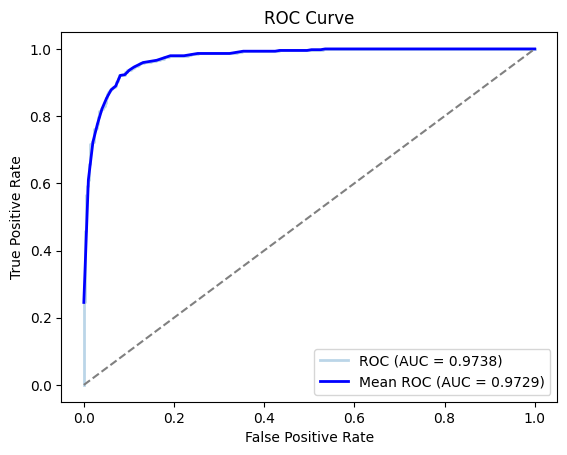

Performance Metrics:
Accuracy: 0.9200
Loss: 0.2590
Sensitivity: 0.9212
Specificity: 0.9189
Precision: 0.9200
MCC: 0.8401


In [31]:
# Evaluate model
evaluation_1_cnn = model_1_cnn.evaluate(X_test, Y_test, verbose=0)
# Loss_1_cnn.append(evaluation_1_cnn[0])
# Accuracy_1_cnn.append(evaluation_1_cnn[1])
loss_1_cnn, accuracy_1_cnn = evaluation_1_cnn

# Predictions
y_pred_probs = model_1_cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
CM_1_cnn = confusion_matrix(y_true=y_true, y_pred=y_pred)
TN, FP, FN, TP = CM_1_cnn.ravel()  # Fixed here to use CM_1_cnn

# Metrics
MCC = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = precision_score(y_true=y_true, y_pred=y_pred, average='weighted')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])  # Assuming binary classification
TPR_1_cnn.append(np.interp(meanFPR, fpr, tpr))
rocauc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC (AUC = {rocauc:0.4f})')

# Plot Mean ROC Curve
meanTPR = np.mean(TPR_1_cnn, axis=0)
meanROC_AUC = auc(meanFPR, meanTPR)
plt.plot(meanFPR, meanTPR, color='b', label=f'Mean ROC (AUC = {meanROC_AUC:0.4f})', lw=2, alpha=1)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display Performance Metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy_1_cnn:.4f}")
print(f"Loss: {loss_1_cnn:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"MCC: {MCC:.4f}")

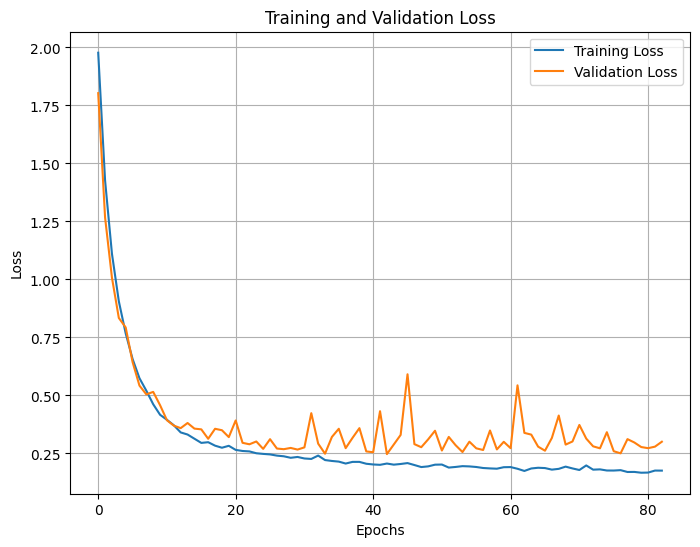

In [32]:
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
plot_loss(history_1_cnn)

In [33]:
import gc

# Explicitly call garbage collection
gc.collect()


13987

## 2_Layer CNN

In [34]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.regularizers import l2

def build_cnn_2_layer(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # First Conv1D Layer
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
                      kernel_regularizer=l2(0.001))(inputs)
    x = layers.BatchNormalization()(x)
    # x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(rate=0.3)(x)

    # Second Conv1D Layer
    x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',
                      kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    # x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(rate=0.3)(x)

    # Global Average Pooling instead of Flatten
    x = layers.GlobalAveragePooling1D()(x)

    # Flatten and Dense Layers
    # x = layers.Flatten()(x)
    x = layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.Dropout(rate=0.4)(x)
    
    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model with a lower learning rate
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [35]:
setEpochNumber = 200  # Epochs
setBatchSizeNumber = 32  # Batch size

# ROC Curve Setup
fig1 = plt.figure(figsize=[12, 12])
TPR_2_cnn = []
meanFPR = np.linspace(0, 1, 100)

# Build and compile the model
model_2_cnn = build_cnn_2_layer(input_shape, num_classes)
model_2_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping callback
callbacks = [EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=40,              # Stop training if no improvement for 40 epochs
    restore_best_weights=True, mode='max')]  # Restore best weights

# Train model
history_2_cnn = model_2_cnn.fit(
    x=X_train,
    y=Y_train,
    # validation_data=(X_test,Y_test),
    validation_split=0.1,  # Split some data for validation (optional)
    batch_size=setBatchSizeNumber,
    epochs=setEpochNumber,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/200
227/227 [==============================] - 6s 16ms/step - loss: 0.7266 - accuracy: 0.8419 - val_loss: 0.7708 - val_accuracy: 0.8706
Epoch 2/200
227/227 [==============================] - 3s 12ms/step - loss: 0.5917 - accuracy: 0.8909 - val_loss: 0.5957 - val_accuracy: 0.8806
Epoch 3/200
227/227 [==============================] - 3s 12ms/step - loss: 0.5433 - accuracy: 0.9041 - val_loss: 0.5375 - val_accuracy: 0.9017
Epoch 4/200
227/227 [==============================] - 3s 12ms/step - loss: 0.5086 - accuracy: 0.9140 - val_loss: 0.5158 - val_accuracy: 0.9179
Epoch 5/200
227/227 [==============================] - 3s 12ms/step - loss: 0.4793 - accuracy: 0.9154 - val_loss: 0.5397 - val_accuracy: 0.8856
Epoch 6/200
227/227 [==============================] - 3s 12ms/step - loss: 0.4538 - accuracy: 0.9200 - val_loss: 0.5093 - val_accuracy: 0.8968
Epoch 7/200
227/227 [==============================] - 3s 12ms/step - loss: 0.4315 - accuracy: 0.9291 - val_loss: 0.4647 - val_accuracy:

<Figure size 1200x1200 with 0 Axes>

In [36]:
model_2_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 101, 1280)]       0         
                                                                 
 conv1d_1 (Conv1D)           (None, 101, 64)           245824    
                                                                 
 batch_normalization_1 (Bat  (None, 101, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 101, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 101, 128)          24704     
                                                                 
 batch_normalization_2 (Bat  (None, 101, 128)          512       
 chNormalization)                                          

28/28 [==============================] - 1s 7ms/step


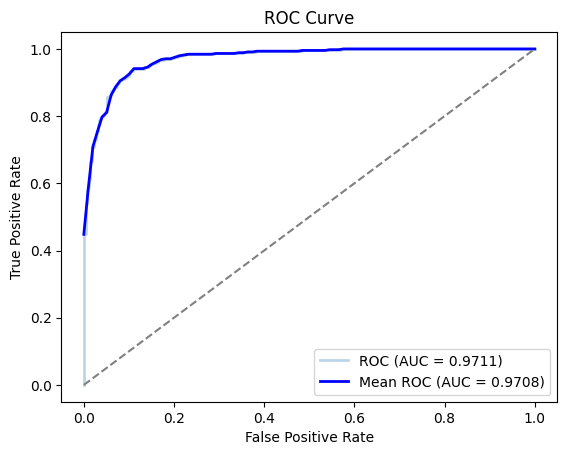

Performance Metrics:
Accuracy: 0.9144
Loss: 0.4363
Sensitivity: 0.9392
Specificity: 0.8896
Precision: 0.9154
MCC: 0.8298


In [37]:
# Evaluate model
evaluation_2_cnn = model_2_cnn.evaluate(X_test, Y_test, verbose=0)
# Loss_1_cnn.append(evaluation_1_cnn[0])
# Accuracy_1_cnn.append(evaluation_1_cnn[1])
loss_2_cnn, accuracy_2_cnn = evaluation_2_cnn

# Predictions
y_pred_probs = model_2_cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
CM_2_cnn = confusion_matrix(y_true=y_true, y_pred=y_pred)
TN, FP, FN, TP = CM_2_cnn.ravel()  # Fixed here to use CM_1_cnn

# Metrics
MCC = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = precision_score(y_true=y_true, y_pred=y_pred, average='weighted')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])  # Assuming binary classification
TPR_2_cnn.append(np.interp(meanFPR, fpr, tpr))
rocauc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC (AUC = {rocauc:0.4f})')

# Plot Mean ROC Curve
meanTPR = np.mean(TPR_2_cnn, axis=0)
meanROC_AUC = auc(meanFPR, meanTPR)
plt.plot(meanFPR, meanTPR, color='b', label=f'Mean ROC (AUC = {meanROC_AUC:0.4f})', lw=2, alpha=1)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display Performance Metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy_2_cnn:.4f}")
print(f"Loss: {loss_2_cnn:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"MCC: {MCC:.4f}")

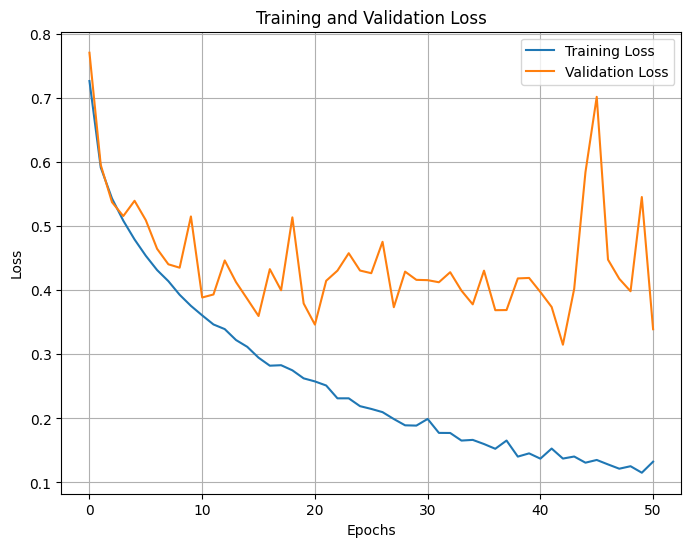

In [38]:
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
plot_loss(history_2_cnn)

In [27]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, matthews_corrcoef, precision_score, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# EarlyStopping callback
callbacks = [EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=40,              # Stop training if no improvement for 40 epochs
    restore_best_weights=True, mode='max')]

def build_cnn_3_layer(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # First Conv1D Layer
    x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
                      kernel_regularizer=l2(0.001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(rate=0.1)(x)

    # Second Conv1D Layer
    x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same',
                      kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(rate=0.1)(x)

    # Third Conv1D Layer
    x = layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same',
                      kernel_regularizer=l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(rate=0.1)(x)

    # Flatten and Dense Layers
    x = layers.Flatten()(x)
    x = layers.Dense(units=128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = layers.Dropout(rate=0.3)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model


In [28]:
from tensorflow.keras.callbacks import EarlyStopping
setEpochNumber = 200  # Epochs
setBatchSizeNumber = 32  # Batch size

# ROC Curve Setup
fig1 = plt.figure(figsize=[12, 12])
TPR_3_cnn = []
meanFPR = np.linspace(0, 1, 100)

# Build and compile the model
model_3_cnn = build_cnn_3_layer(input_shape, num_classes)
model_3_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping callback
callbacks = [EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=40,              # Stop training if no improvement for 40 epochs
    restore_best_weights=True, mode='max')]  # Restore best weights

# Train model
history_3_cnn = model_3_cnn.fit(
    x=X_train,
    y=Y_train,
    # validation_data=(X_test,Y_test),
    validation_split=0.1,  # Split some data for validation (optional)
    batch_size=setBatchSizeNumber,
    epochs=setEpochNumber,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/200


I0000 00:00:1733092674.300490     161 service.cc:145] XLA service 0x7b53d0db7620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733092674.300542     161 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733092674.300546     161 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733092674.511986     161 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - 25s 22ms/step - loss: 1.0354 - accuracy: 0.8239 - val_loss: 0.9948 - val_accuracy: 0.8557
Epoch 2/200
227/227 [==============================] - 3s 14ms/step - loss: 0.8704 - accuracy: 0.8907 - val_loss: 0.8671 - val_accuracy: 0.8794
Epoch 3/200
227/227 [==============================] - 3s 14ms/step - loss: 0.8379 - accuracy: 0.9005 - val_loss: 0.8309 - val_accuracy: 0.9030
Epoch 4/200
227/227 [==============================] - 3s 13ms/step - loss: 0.7977 - accuracy: 0.9122 - val_loss: 0.7967 - val_accuracy: 0.9129
Epoch 5/200
227/227 [==============================] - 3s 13ms/step - loss: 0.7732 - accuracy: 0.9175 - val_loss: 0.7842 - val_accuracy: 0.9154
Epoch 6/200
227/227 [==============================] - 3s 13ms/step - loss: 0.7441 - accuracy: 0.9269 - val_loss: 0.7775 - val_accuracy: 0.9080
Epoch 7/200
227/227 [==============================] - 3s 13ms/step - loss: 0.7374 - accuracy: 0.9303 - val_loss: 0.7758 - val_accuracy: 0.9055
Epo

<Figure size 1200x1200 with 0 Axes>

In [29]:
final_train_loss = history_3_cnn.history['loss'][-1]
final_train_accuracy = history_3_cnn.history['accuracy'][-1]
final_val_loss = history_3_cnn.history['val_loss'][-1]
final_val_accuracy = history_3_cnn.history['val_accuracy'][-1]

# Print the results
print("Final Training Loss: {:.4f}".format(final_train_loss))
print("Final Training Accuracy: {:.2f}%".format(final_train_accuracy * 100))
print("Final Validation Loss: {:.4f}".format(final_val_loss))
print("Final Validation Accuracy: {:.2f}%".format(final_val_accuracy * 100))

Final Training Loss: 0.1226
Final Training Accuracy: 99.27%
Final Validation Loss: 0.5273
Final Validation Accuracy: 92.04%


In [30]:
# Print Model Summary
model_3_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 101, 1280)]       0         
                                                                 
 conv1d_3 (Conv1D)           (None, 101, 64)           245824    
                                                                 
 batch_normalization_3 (Bat  (None, 101, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 50, 64)            0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 50, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 50, 128)           2470

28/28 [==============================] - 1s 8ms/step


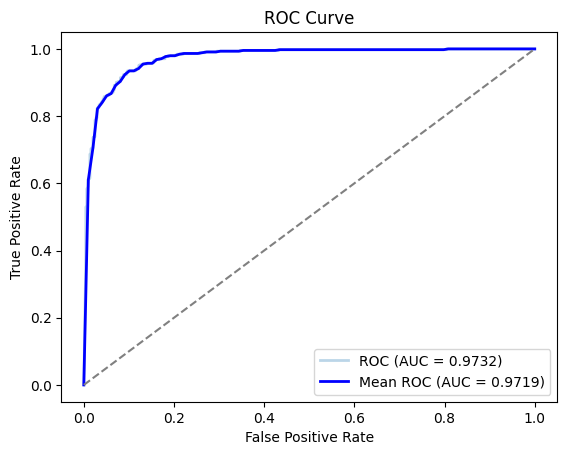

Performance Metrics:
Accuracy: 0.9133
Loss: 0.6393
Sensitivity: 0.9077
Specificity: 0.9189
Precision: 0.9133
MCC: 0.8266


In [31]:
# Evaluate model
evaluation_3_cnn = model_3_cnn.evaluate(X_test, Y_test, verbose=0)
# Loss_1_cnn.append(evaluation_1_cnn[0])
# Accuracy_1_cnn.append(evaluation_1_cnn[1])
loss_3_cnn, accuracy_3_cnn = evaluation_3_cnn

# Predictions
y_pred_probs = model_3_cnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
CM_3_cnn = confusion_matrix(y_true=y_true, y_pred=y_pred)
TN, FP, FN, TP = CM_3_cnn.ravel()  # Fixed here to use CM_1_cnn

# Metrics
MCC = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = precision_score(y_true=y_true, y_pred=y_pred, average='weighted')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])  # Assuming binary classification
TPR_3_cnn.append(np.interp(meanFPR, fpr, tpr))
rocauc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC (AUC = {rocauc:0.4f})')

# Plot Mean ROC Curve
meanTPR = np.mean(TPR_3_cnn, axis=0)
meanROC_AUC = auc(meanFPR, meanTPR)
plt.plot(meanFPR, meanTPR, color='b', label=f'Mean ROC (AUC = {meanROC_AUC:0.4f})', lw=2, alpha=1)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display Performance Metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy_3_cnn:.4f}")
print(f"Loss: {loss_3_cnn:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"MCC: {MCC:.4f}")

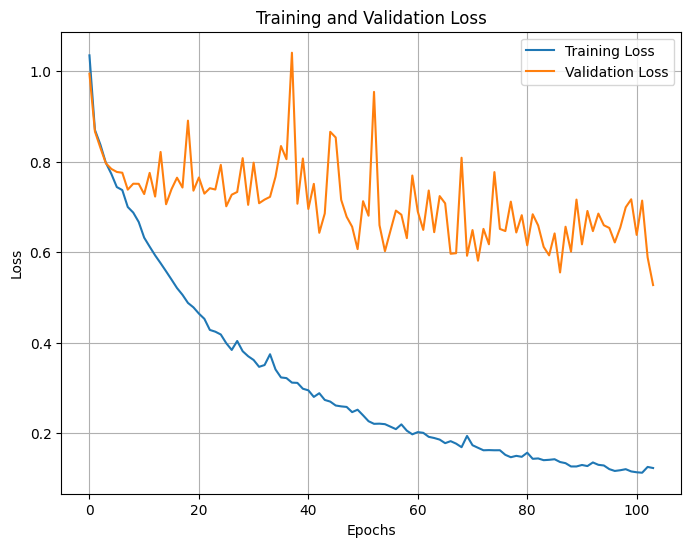

In [33]:
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
plot_loss(history_3_cnn)

In [ ]:
import pandas as pd

# Get the number of trainable parameters for each model
params_cnn_1 = model_1_cnn.count_params()
params_cnn_2 = model_2_cnn.count_params()
params_cnn_3 = model_3_cnn.count_params()

# Create a dictionary of results
results = {
    'Model Name': ['CNN 1 Layer', 'CNN 2 Layers', 'CNN 3 Layers'],
    'Parameters': [params_cnn_1, params_cnn_2, params_cnn_3],
    'Test Accuracy': [accuracy_1_cnn, accuracy_2_cnn, accuracy_3_cnn],
    'Test Loss': [loss_1_cnn, loss_2_cnn, loss_3_cnn]
}

# Convert dictionary to DataFrame
results_df = pd.DataFrame(results)

# Display the table
print(results_df)


In [ ]:
## 1-Layer CNN with Multi-Attention

In [34]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, MultiHeadAttention, Add, LayerNormalization, Flatten, Dense
from tensorflow.keras import models
import tensorflow as tf

def build_model_1_cnn_atten(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First convolutional layer with BatchNormalization and Dropout
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',
               kernel_regularizer=l2(0.001))(inputs)  # Increase filters and L2 regularization
    x = BatchNormalization()(x)
    x = Dropout(rate=0.3)(x)  # Increase dropout to combat overfitting

    # Attention mechanism
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64, dropout=0.3)(x, x)  # Increase dropout in attention
    attention_output = Add()([x, attention_output])
    attention_output = LayerNormalization()(attention_output)

    # Further layers with additional BatchNormalization
    x = attention_output
    x = Flatten()(x)
    x = Dense(units=256, activation='relu', kernel_regularizer=l2(0.001))(x)  # Increase units in dense layer
    x = BatchNormalization()(x)  # Add BatchNormalization after Dense
    x = Dropout(rate=0.4)(x)  # Increased dropout to regularize more
    x = Dense(units=128, activation='relu', kernel_regularizer=l2(0.001))(x)  # Deeper layer with more units
    x = Dropout(rate=0.4)(x)

    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Build and return the model
    model = models.Model(inputs=inputs, outputs=output)
    return model

In [35]:
setEpochNumber = 200  # Epochs
setBatchSizeNumber = 32  # Batch size

# ROC Curve Setup
fig1 = plt.figure(figsize=[12, 12])
TPR_1_cnn_atten = []
meanFPR = np.linspace(0, 1, 100)

# Build and compile the model
model_1_cnn_atten = build_model_1_cnn_atten(input_shape, num_classes)
model_1_cnn_atten.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping callback
callbacks = [EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=40,              # Stop training if no improvement for 40 epochs
    restore_best_weights=True, mode='max')]  # Restore best weights

# Train model
history_1_cnn_atten = model_1_cnn_atten.fit(
    x=X_train,
    y=Y_train,
    # validation_data=(X_test,Y_test),
    validation_split=0.1,  # Split some data for validation (optional)
    batch_size=setBatchSizeNumber,
    epochs=setEpochNumber,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/200
227/227 [==============================] - 12s 25ms/step - loss: 1.3123 - accuracy: 0.7819 - val_loss: 1.0632 - val_accuracy: 0.8744
Epoch 2/200
227/227 [==============================] - 4s 17ms/step - loss: 1.1091 - accuracy: 0.8637 - val_loss: 1.1392 - val_accuracy: 0.8470
Epoch 3/200
227/227 [==============================] - 4s 17ms/step - loss: 1.0525 - accuracy: 0.8756 - val_loss: 1.1322 - val_accuracy: 0.8769
Epoch 4/200
227/227 [==============================] - 4s 18ms/step - loss: 1.0184 - accuracy: 0.8848 - val_loss: 1.0337 - val_accuracy: 0.8794
Epoch 5/200
227/227 [==============================] - 4s 18ms/step - loss: 0.9781 - accuracy: 0.8934 - val_loss: 0.9261 - val_accuracy: 0.9117
Epoch 6/200
227/227 [==============================] - 4s 18ms/step - loss: 0.9364 - accuracy: 0.9063 - val_loss: 0.9230 - val_accuracy: 0.9055
Epoch 7/200
227/227 [==============================] - 4s 18ms/step - loss: 0.9107 - accuracy: 0.9031 - val_loss: 0.8968 - val_accuracy

<Figure size 1200x1200 with 0 Axes>

In [36]:
model_1_cnn_atten.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 101, 1280)]          0         []                            
                                                                                                  
 conv1d_6 (Conv1D)           (None, 101, 64)              245824    ['input_3[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 101, 64)              256       ['conv1d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 dropout_8 (Dropout)         (None, 101, 64)              0         ['batch_normalization_6[

28/28 [==============================] - 1s 11ms/step


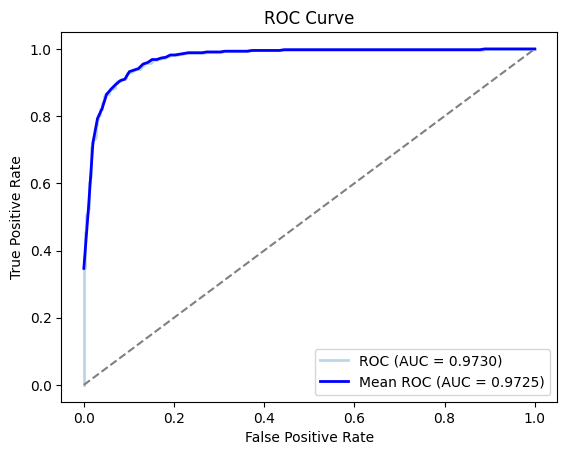

Performance Metrics:
Accuracy: 0.9122
Loss: 0.7747
Sensitivity: 0.9077
Specificity: 0.9167
Precision: 0.9122
MCC: 0.8244


In [37]:
# Evaluate model
evaluation_1_cnn_atten = model_1_cnn_atten.evaluate(X_test, Y_test, verbose=0)
# Loss_1_cnn.append(evaluation_1_cnn[0])
# Accuracy_1_cnn.append(evaluation_1_cnn[1])
loss_1_cnn_atten, accuracy_1_cnn_atten = evaluation_1_cnn_atten

# Predictions
y_pred_probs = model_1_cnn_atten.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
CM_1_cnn_atten = confusion_matrix(y_true=y_true, y_pred=y_pred)
TN, FP, FN, TP = CM_1_cnn_atten.ravel()  # Fixed here to use CM_1_cnn

# Metrics
MCC = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = precision_score(y_true=y_true, y_pred=y_pred, average='weighted')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])  # Assuming binary classification
TPR_1_cnn_atten.append(np.interp(meanFPR, fpr, tpr))
rocauc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC (AUC = {rocauc:0.4f})')

# Plot Mean ROC Curve
meanTPR = np.mean(TPR_1_cnn_atten, axis=0)
meanROC_AUC = auc(meanFPR, meanTPR)
plt.plot(meanFPR, meanTPR, color='b', label=f'Mean ROC (AUC = {meanROC_AUC:0.4f})', lw=2, alpha=1)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display Performance Metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy_1_cnn_atten:.4f}")
print(f"Loss: {loss_1_cnn_atten:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"MCC: {MCC:.4f}")

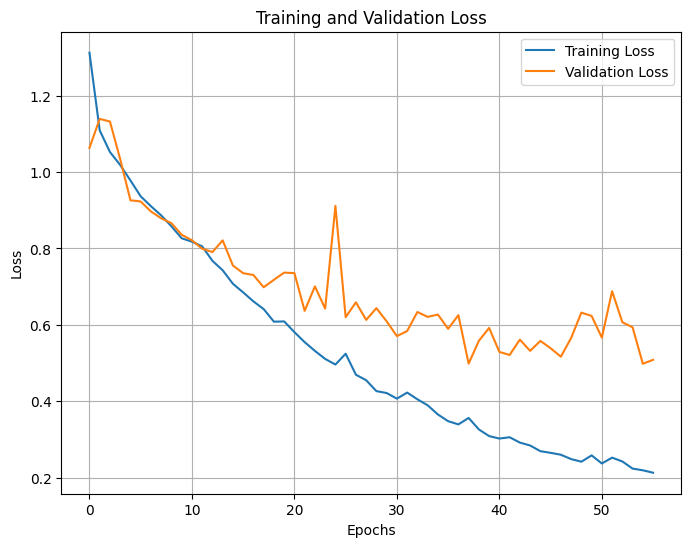

In [38]:
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
plot_loss(history_1_cnn_atten)

In [39]:
def build_model_self(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Initial convolution block
    x = Conv1D(128, 3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)  # Down-sample to reduce sequence length
    
    # Self-Attention Mechanism
    x = SeqSelfAttention(attention_activation='relu')(x)
    
    # Fully connected layers
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=output)


In [40]:
setEpochNumber = 200  # Epochs
setBatchSizeNumber = 32  # Batch size

# ROC Curve Setup
fig1 = plt.figure(figsize=[12, 12])
TPR_1_self = []
meanFPR = np.linspace(0, 1, 100)

# Build and compile the model
model_1_self = build_model_self(input_shape, num_classes)
model_1_self.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping callback
callbacks = [EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=40,              # Stop training if no improvement for 40 epochs
    restore_best_weights=True, mode='max')]  # Restore best weights

# Train model
history_1_self = model_1_self.fit(
    x=X_train,
    y=Y_train,
    # validation_data=(X_test,Y_test),
    validation_split=0.1,  # Split some data for validation (optional)
    batch_size=setBatchSizeNumber,
    epochs=setEpochNumber,
    verbose=1,
    callbacks=callbacks
)


/opt/conda/lib/python3.10/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/200
227/227 [==============================] - 8s 20ms/step - loss: 0.3541 - accuracy: 0.8384 - val_loss: 0.3877 - val_accuracy: 0.8632
Epoch 2/200
227/227 [==============================] - 3s 13ms/step - loss: 0.2609 - accuracy: 0.8878 - val_loss: 0.2322 - val_accuracy: 0.9005
Epoch 3/200
227/227 [==============================] - 3s 13ms/step - loss: 0.2247 - accuracy: 0.9050 - val_loss: 0.2117 - val_accuracy: 0.9030
Epoch 4/200
227/227 [==============================] - 3s 13ms/step - loss: 0.2067 - accuracy: 0.9154 - val_loss: 0.2831 - val_accuracy: 0.8644
Epoch 5/200
227/227 [==============================] - 3s 13ms/step - loss: 0.1922 - accuracy: 0.9179 - val_loss: 0.2378 - val_accuracy: 0.9042
Epoch 6/200
227/227 [==============================] - 3s 13ms/step - loss: 0.1695 - accuracy: 0.9296 - val_loss: 0.1982 - val_accuracy: 0.9229
Epoch 7/200
227/227 [==============================] - 3s 13ms/step - loss: 0.1530 - accuracy: 0.9378 - val_loss: 0.3281 - val_accuracy:

<Figure size 1200x1200 with 0 Axes>

In [41]:
model_1_self.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 101, 1280)]       0         
                                                                 
 conv1d_7 (Conv1D)           (None, 101, 128)          491648    
                                                                 
 batch_normalization_8 (Bat  (None, 101, 128)          512       
 chNormalization)                                                
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 50, 128)           0         
 g1D)                                                            
                                                                 
 seq_self_attention (SeqSel  (None, 50, 128)           8257      
 fAttention)                                                     
                                                           

28/28 [==============================] - 1s 9ms/step


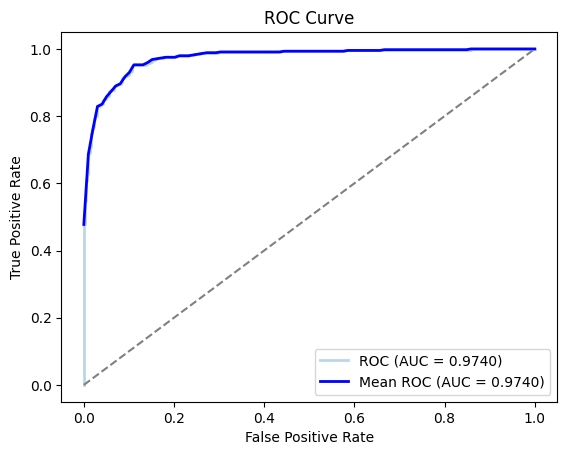

Performance Metrics:
Accuracy: 0.9065
Loss: 0.3096
Sensitivity: 0.8694
Specificity: 0.9437
Precision: 0.9088
MCC: 0.8153


In [42]:
# Evaluate model
evaluation_1_self = model_1_self.evaluate(X_test, Y_test, verbose=0)
# Loss_1_cnn.append(evaluation_1_cnn[0])
# Accuracy_1_cnn.append(evaluation_1_cnn[1])
loss_1_self, accuracy_1_self = evaluation_1_self

# Predictions
y_pred_probs = model_1_self.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
CM_1_self = confusion_matrix(y_true=y_true, y_pred=y_pred)
TN, FP, FN, TP = CM_1_self.ravel()  # Fixed here to use CM_1_cnn

# Metrics
MCC = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = precision_score(y_true=y_true, y_pred=y_pred, average='weighted')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])  # Assuming binary classification
TPR_1_self.append(np.interp(meanFPR, fpr, tpr))
rocauc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC (AUC = {rocauc:0.4f})')

# Plot Mean ROC Curve
meanTPR = np.mean(TPR_1_self, axis=0)
meanROC_AUC = auc(meanFPR, meanTPR)
plt.plot(meanFPR, meanTPR, color='b', label=f'Mean ROC (AUC = {meanROC_AUC:0.4f})', lw=2, alpha=1)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display Performance Metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy_1_self:.4f}")
print(f"Loss: {loss_1_self:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"MCC: {MCC:.4f}")

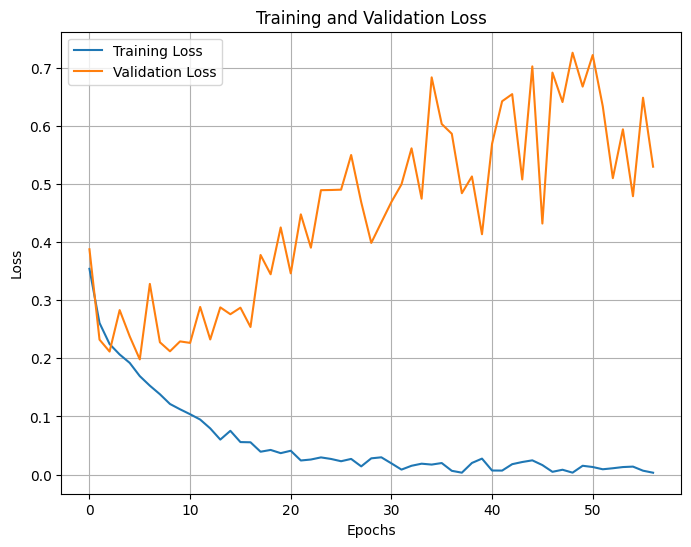

In [44]:
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
plot_loss(history_1_self)

In [20]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense, Input
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import MultiHeadAttention, Activation
from tcn import TCN  # Ensure you have the Temporal Convolutional Network (TCN) library installed

def ourmodel(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    a = Conv1D(64, 3, activation='relu', padding='valid')(inputs)
    a = BatchNormalization()(a)
    a = Dropout(0.4)(a)
    
    # #     a = MaxPooling1D(pool_size=3, strides=1,padding='valid')(a)
    # b = Conv1D(128, 3, activation='relu', padding='valid')(a)
    # b = BatchNormalization()(b)
    # b = Dropout(0.3)(b)
    
    # c = Conv1D(256, 3, activation='relu', padding='valid')(b)
    # c = MaxPooling1D(pool_size=3, strides=1, padding='valid')(c)
    # c = Dropout(0.2)(c)
    
    # d = Bidirectional(LSTM(128,return_sequences=True))(c)
    d = TCN(nb_filters=128, kernel_size=5, dropout_rate=0.3, nb_stacks=1,  dilations=[1, 2, 4,8],
            return_sequences=True,activation='relu',padding='same',use_skip_connections=True)(a)
    
    d = MultiHeadAttention(num_heads=4,key_dim=128)(d,d)
    d = Activation('relu')(d)
    
    
    d = Flatten()(d)
    
    e = Dense(128, activation='relu', name='FC3')(d)
    e = Dropout(rate=0.5)(e)
    
    e = Dense(64, activation='relu', name='FC2')(e)
    # e = Dropout(0.4)(e)

    e = Dense(32, activation='relu', name='FC4')(e)
    # x = Dropout(0.3)(e)

    output = Dense(2, activation='softmax', name='Output')(e)

    return Model(inputs=[inputs], outputs=[output])



Epoch 1/200


I0000 00:00:1733094212.592484     136 service.cc:145] XLA service 0x7a34aa377970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733094212.592543     136 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733094212.592548     136 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733094212.774786     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - 30s 37ms/step - loss: 0.6428 - accuracy: 0.5986 - val_loss: 0.6630 - val_accuracy: 0.5224
Epoch 2/200
227/227 [==============================] - 5s 22ms/step - loss: 0.3375 - accuracy: 0.8613 - val_loss: 0.5048 - val_accuracy: 0.7251
Epoch 3/200
227/227 [==============================] - 5s 22ms/step - loss: 0.2780 - accuracy: 0.8860 - val_loss: 0.3450 - val_accuracy: 0.8420
Epoch 4/200
227/227 [==============================] - 5s 22ms/step - loss: 0.2388 - accuracy: 0.9042 - val_loss: 0.3577 - val_accuracy: 0.8383
Epoch 5/200
227/227 [==============================] - 5s 22ms/step - loss: 0.2257 - accuracy: 0.9100 - val_loss: 0.2461 - val_accuracy: 0.8769
Epoch 6/200
227/227 [==============================] - 5s 22ms/step - loss: 0.2074 - accuracy: 0.9168 - val_loss: 0.2483 - val_accuracy: 0.8868
Epoch 7/200
227/227 [==============================] - 5s 22ms/step - loss: 0.1932 - accuracy: 0.9258 - val_loss: 0.2463 - val_accuracy: 0.8893
Epo

/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 2s 12ms/step
AUC: 0.9691380569758947
Accuracy: 0.9042792916297913
Loss: 0.2689429521560669
Sensitivity: 0.9414414414414415
Specificity: 0.8671171171171171
Precision: 0.8763102725366876


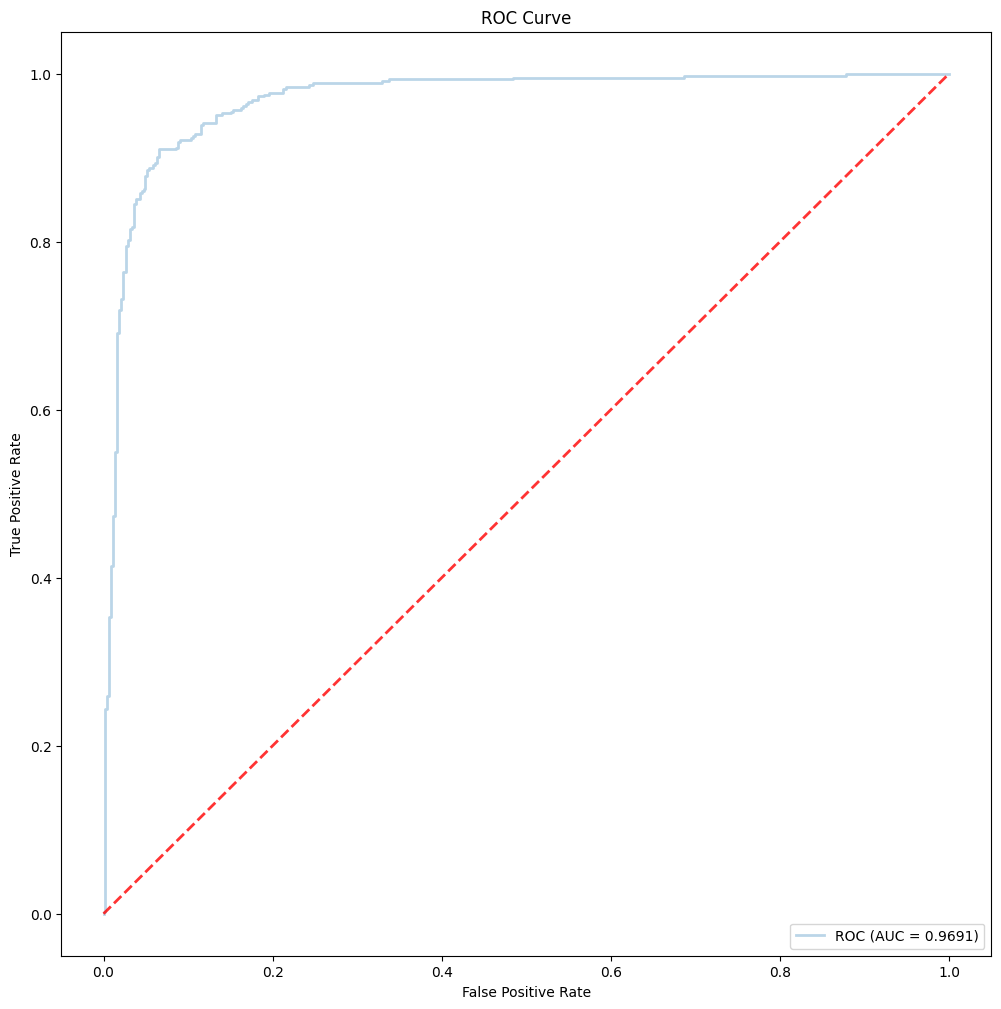

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Parameters
setEpochNumber = 200
setBatchSizeNumber = 32

# ROC Curve setup
fig1 = plt.figure(figsize=[12, 12])
TPR = []
meanFPR = np.linspace(0, 1, 100)

# Compile and train the model
model = ourmodel(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# EarlyStopping callback
callbacks = [EarlyStopping(
    monitor='val_accuracy', 
    patience=40, 
    restore_best_weights=True,
    mode='max')]

# Train the model
results = model.fit(x=X_train, y=Y_train,
                    batch_size=setBatchSizeNumber, epochs=setEpochNumber,
                    validation_split=0.1, verbose=1, callbacks=callbacks)

# Save the trained model
model_path = '/kaggle/working/Model.h5'
model.save(model_path)

# Evaluate the model
evaluate = model.evaluate(X_test, Y_test, verbose=0)
loss = evaluate[0]
accuracy = evaluate[1]

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
CM = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = CM.ravel()

# Metrics
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = precision_score(y_true, y_pred, average='binary')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
TPR.append(np.interp(meanFPR, fpr, tpr))
rocauc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC (AUC = {rocauc:0.4f})')

# Print metrics
print('AUC:', rocauc)
print('Accuracy:', accuracy)
print('Loss:', loss)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('Precision:', precision)

# Plot ROC Curve
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 101, 1280)]          0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 99, 64)               245824    ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 99, 64)               256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 99, 64)               0         ['batch_normalization[0][0

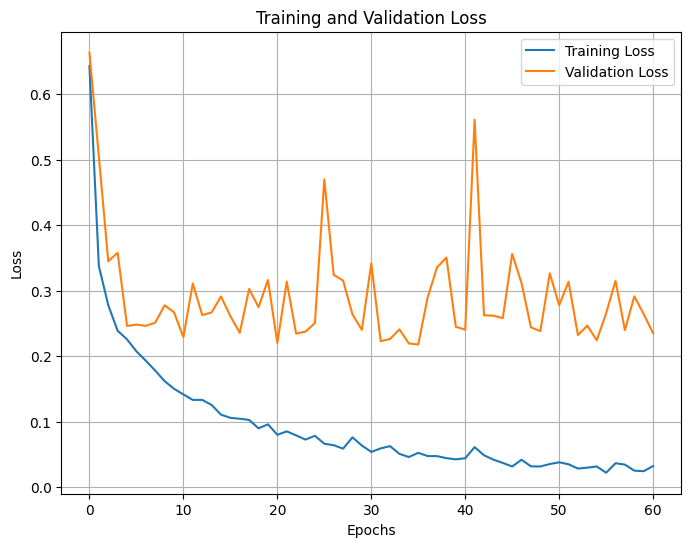

In [24]:
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
plot_loss(results)

In [25]:
def model_single(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Initial convolution block
    x = Conv1D(512, 3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x) 
    x = Dropout(0.5)(x) 
    
    # Multi-Head Attention Layer
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    attention_output = Dropout(0.3)(attention_output)
    
    # Add attention output back to the original input (skip connection)
    x = x + attention_output
    
    # Fully connected layers
    x = Flatten()(x)
    # x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
    x = Dropout(0.7)(x)  # Increased dropout rate
    x = Dense(32, activation='relu')(x)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(x)
    
    # Compile the model with a lower learning rate
    optimizer = Adam(learning_rate=0.0001)  # Smaller learning rate
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [26]:
setEpochNumber = 200  # Epochs
setBatchSizeNumber = 32  # Batch size

# ROC Curve Setup
fig1 = plt.figure(figsize=[12, 12])
TPR_1_self = []
meanFPR = np.linspace(0, 1, 100)

# Build and compile the model
model_1_self = model_single(input_shape, num_classes)
model_1_self.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping callback
callbacks = [EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=40,              # Stop training if no improvement for 40 epochs
    restore_best_weights=True, mode='max')]  # Restore best weights

# Train model
history_1_self = model_1_self.fit(
    x=X_train,
    y=Y_train,
    # validation_data=(X_test,Y_test),
    validation_split=0.1,  # Split some data for validation (optional)
    batch_size=setBatchSizeNumber,
    epochs=setEpochNumber,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/200
227/227 [==============================] - 10s 27ms/step - loss: 0.6241 - accuracy: 0.7653 - val_loss: 0.5034 - val_accuracy: 0.8595
Epoch 2/200
227/227 [==============================] - 4s 20ms/step - loss: 0.3224 - accuracy: 0.8662 - val_loss: 0.2965 - val_accuracy: 0.8868
Epoch 3/200
227/227 [==============================] - 4s 20ms/step - loss: 0.2681 - accuracy: 0.8811 - val_loss: 0.2540 - val_accuracy: 0.8843
Epoch 4/200
227/227 [==============================] - 5s 20ms/step - loss: 0.2386 - accuracy: 0.8991 - val_loss: 0.2230 - val_accuracy: 0.8980
Epoch 5/200
227/227 [==============================] - 5s 20ms/step - loss: 0.2339 - accuracy: 0.9010 - val_loss: 0.2149 - val_accuracy: 0.9129
Epoch 6/200
227/227 [==============================] - 5s 20ms/step - loss: 0.2199 - accuracy: 0.9129 - val_loss: 0.1988 - val_accuracy: 0.9241
Epoch 7/200
227/227 [==============================] - 5s 20ms/step - loss: 0.2047 - accuracy: 0.9144 - val_loss: 0.2246 - val_accuracy

<Figure size 1200x1200 with 0 Axes>

In [27]:
model_1_self.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 101, 1280)]          0         []                            
                                                                                                  
 conv1d_1 (Conv1D)           (None, 101, 512)             1966592   ['input_2[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 101, 512)             2048      ['conv1d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 50, 512)              0         ['batch_normalization_1[

28/28 [==============================] - 0s 11ms/step


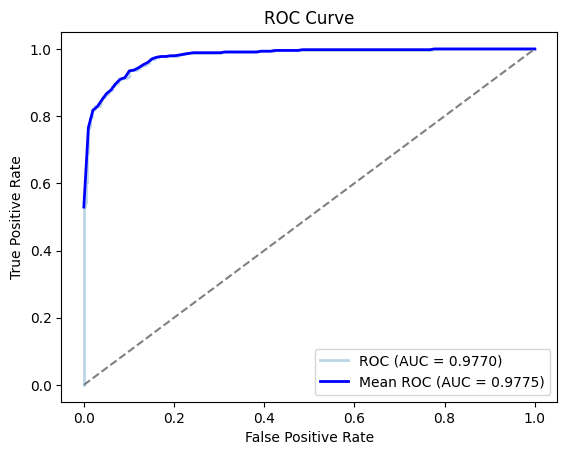

Performance Metrics:
Accuracy: 0.9133
Loss: 0.3050
Sensitivity: 0.9122
Specificity: 0.9144
Precision: 0.9133
MCC: 0.8266


In [29]:
from sklearn.metrics import matthews_corrcoef

# Evaluate model
evaluation_1_self = model_1_self.evaluate(X_test, Y_test, verbose=0)
# Loss_1_cnn.append(evaluation_1_cnn[0])
# Accuracy_1_cnn.append(evaluation_1_cnn[1])
loss_1_self, accuracy_1_self = evaluation_1_self

# Predictions
y_pred_probs = model_1_self.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
CM_1_self = confusion_matrix(y_true=y_true, y_pred=y_pred)
TN, FP, FN, TP = CM_1_self.ravel()  # Fixed here to use CM_1_cnn

# Metrics
MCC = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = precision_score(y_true=y_true, y_pred=y_pred, average='weighted')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])  # Assuming binary classification
TPR_1_self.append(np.interp(meanFPR, fpr, tpr))
rocauc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC (AUC = {rocauc:0.4f})')

# Plot Mean ROC Curve
meanTPR = np.mean(TPR_1_self, axis=0)
meanROC_AUC = auc(meanFPR, meanTPR)
plt.plot(meanFPR, meanTPR, color='b', label=f'Mean ROC (AUC = {meanROC_AUC:0.4f})', lw=2, alpha=1)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Display Performance Metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy_1_self:.4f}")
print(f"Loss: {loss_1_self:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"MCC: {MCC:.4f}")

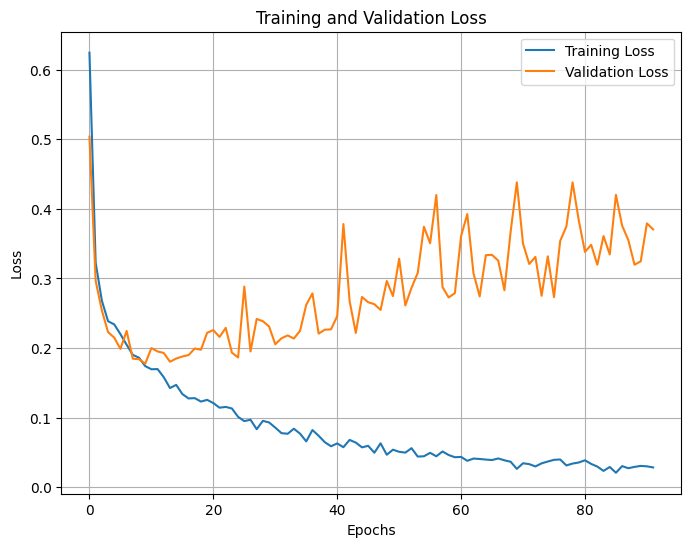

In [30]:
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()
plot_loss(history_1_self)